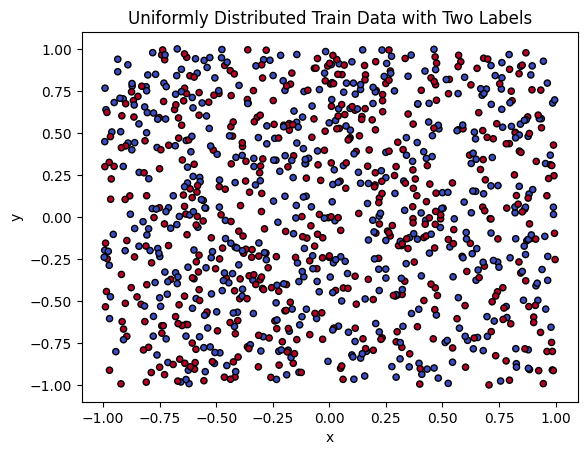

 24%|██▍       | 242/1000 [00:01<00:03, 228.78it/s]

Epoch 200: train_acc=0.629, test_acc=0.476


 44%|████▍     | 438/1000 [00:02<00:02, 195.22it/s]

Epoch 400: train_acc=0.657, test_acc=0.479


 62%|██████▎   | 625/1000 [00:03<00:01, 191.80it/s]

Epoch 600: train_acc=0.679, test_acc=0.493


 83%|████████▎ | 829/1000 [00:04<00:00, 218.29it/s]

Epoch 800: train_acc=0.695, test_acc=0.492


100%|██████████| 1000/1000 [00:04<00:00, 201.36it/s]


Epoch 1000: train_acc=0.718, test_acc=0.497
Final train_acc 0.718000054359436
Final test_acc 0.4970000088214874


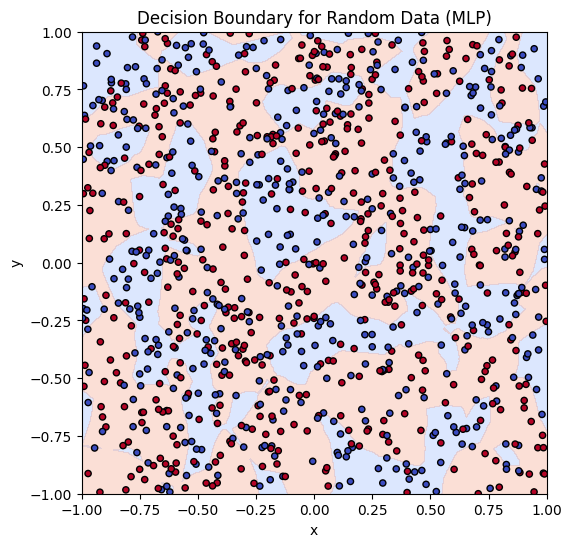

In [1]:
import torch
from sklearn.datasets import make_moons
import numpy as np
from tqdm import tqdm

# Example 4: Classification with MLP (instead of KAN)

import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    'seed': 2024,
    'moon_noise': 0.0,
    'bounds': (-1,1),
    #'optimizer': 'LBFGS',
    'learning_rate': 1e-3,
    #'width': [2, 2, 2, 2, 2],  # MLP width, can be changed for experiments
    #'width': [2,1000,1000,1000,1000,1000,1000,2]
    'width': [2,100,100,100,100,100,100,2]
}
args = Args(**args_dict)

torch.manual_seed(args.seed)
np.random.seed(args.seed)

# Create uniformly distributed train and test datasets with two labels
rng = np.random.RandomState(args.seed)
n_samples = 1000
bounds = args.bounds

# Train data
train_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
train_label = rng.randint(0, 2, size=n_samples)

# Test data
test_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
test_label = rng.randint(0, 2, size=n_samples)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']

plt.scatter(train_input[:, 0], train_input[:, 1], c=train_label, cmap='coolwarm', edgecolor='k', s=20)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Uniformly Distributed Train Data with Two Labels')
plt.show()

# Define a simple MLP
class MLP(nn.Module):
    def __init__(self, width):
        super().__init__()
        layers = []
        for i in range(len(width)-1):
            layers.append(nn.Linear(width[i], width[i+1]))
            if i < len(width)-2:
                layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

model = MLP(args.width).to(device)

def train_acc():
    with torch.no_grad():
        logits = model(dataset['train_input'])
        return torch.mean((torch.argmax(logits, dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    with torch.no_grad():
        logits = model(dataset['test_input'])
        return torch.mean((torch.argmax(logits, dim=1) == dataset['test_label']).type(dtype))

# Training loop
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
epochs = 1000
for epoch in tqdm(range(epochs)):
    model.train()
    optimizer.zero_grad()
    logits = model(dataset['train_input'])
    loss = loss_fn(logits, dataset['train_label'])
    loss.backward()
    optimizer.step()
    if (epoch+1) % 200 == 0:
        print(f"Epoch {epoch+1}: train_acc={train_acc().item():.3f}, test_acc={test_acc().item():.3f}")

print("Final train_acc", train_acc().item())
print("Final test_acc", test_acc().item())

# Plot decision boundary
bounds = args.bounds
xx, yy = torch.meshgrid(
    torch.linspace(*bounds, 2000, device=device),
    torch.linspace(*bounds, 2000, device=device),
    indexing='ij'
)
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1).type(dtype).to(device)

with torch.no_grad():
    logits = model(grid)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

plt.figure(figsize=(6, 6))
plt.contourf(
    xx.cpu().numpy(), yy.cpu().numpy(),
    preds.reshape(xx.shape),
    levels=1, alpha=0.3, cmap='coolwarm'
)
X_cpu = X.cpu().numpy()
y_cpu = y.cpu().numpy()
plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu, edgecolor='k', cmap='coolwarm', s=20)
plt.xlim(bounds)
plt.ylim(bounds)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary for Random Data (MLP)')
plt.show()

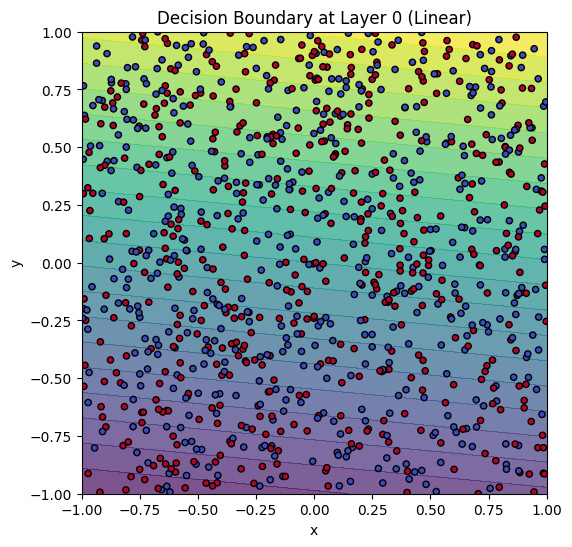

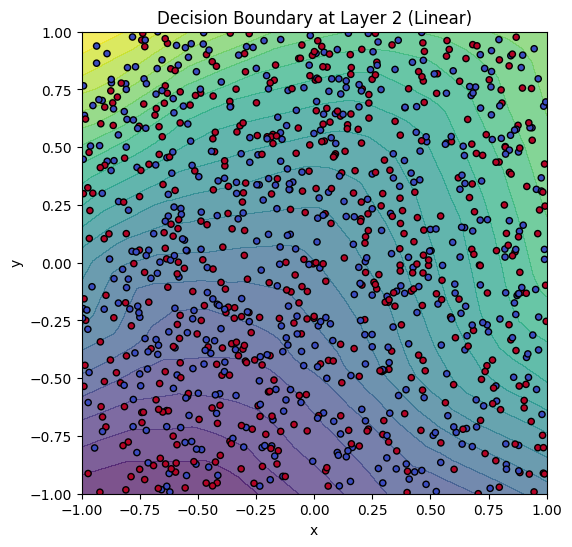

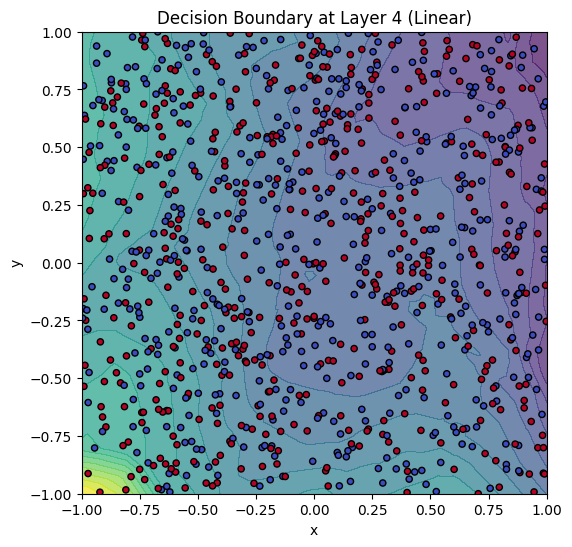

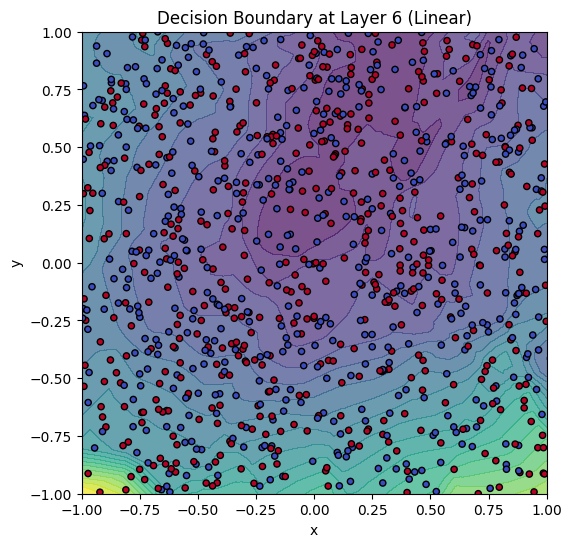

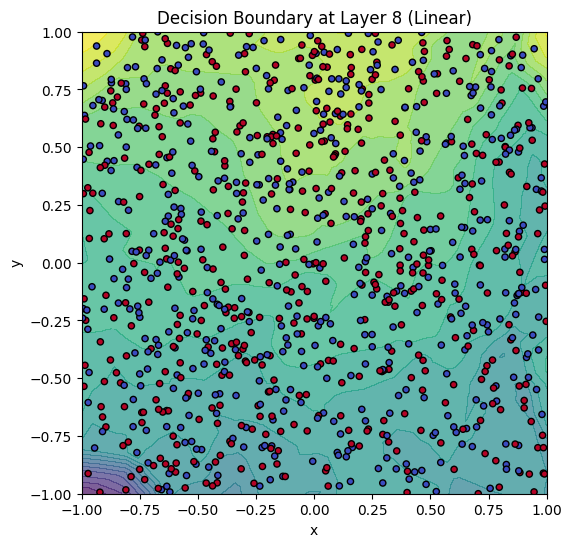

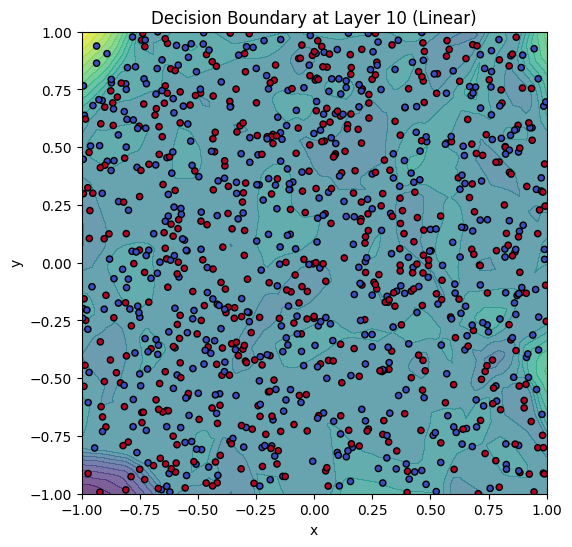

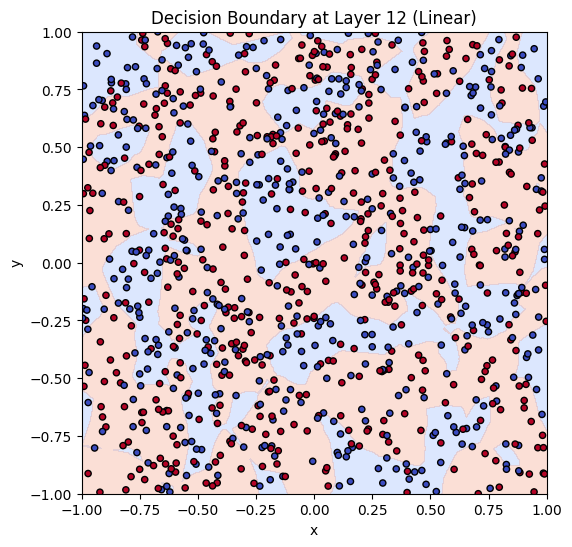

In [2]:
# Visualize decision boundaries for each layer of the MLP

def plot_decision_boundary_for_layer(model, layer_idx, grid, xx, yy, device):
    # Forward through layers up to layer_idx (inclusive)
    x = grid
    for i, layer in enumerate(model.net):
        x = layer(x)
        if i == layer_idx:
            break
    # If not last layer, apply softmax to get probabilities for 2 classes
    if x.shape[1] == 2:
        preds = torch.argmax(x, dim=1).cpu().numpy()
    else:
        # For hidden layers, use the first neuron as a proxy for visualization
        preds = x[:, 0].detach().cpu().numpy()
        # Normalize for visualization
        preds = (preds - preds.min()) / (preds.max() - preds.min())
    plt.figure(figsize=(6, 6))
    if x.shape[1] == 2:
        plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), preds.reshape(xx.shape), levels=1, alpha=0.3, cmap='coolwarm')
    else:
        plt.contourf(xx.cpu().numpy(), yy.cpu().numpy(), preds.reshape(xx.shape), levels=20, alpha=0.7, cmap='viridis')
    plt.scatter(X_cpu[:, 0], X_cpu[:, 1], c=y_cpu, edgecolor='k', cmap='coolwarm', s=20)
    plt.xlim(bounds)
    plt.ylim(bounds)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Decision Boundary at Layer {layer_idx} ({type(model.net[layer_idx]).__name__})')
    plt.show()

# Plot for each Linear layer (before activation)
for idx, layer in enumerate(model.net):
    if isinstance(layer, torch.nn.Linear):
        plot_decision_boundary_for_layer(model, idx, grid, xx, yy, device)